In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(4,4)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d

digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_mask = np.isin(y_train, [1, 7])
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, [1, 7])
X_test, y_test = X_test[test_mask], y_test[test_mask]

#
# X_train = X_train.reshape(X_train.shape[0], 16, 4)
# X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [7]:
X_train.shape

(283, 8, 8)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# (283, 16, 2, 2)를 (283, 16, 4)로 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [11]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [12]:
X_train.shape

(283, 4, 16)

In [13]:
X_train

array([[[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [16., 16., 13., ..., 11.,  1.,  0.],
        [ 0.,  0.,  2., ...,  0.,  2., 15.],
        [15., 16.,  9., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  4., ...,  0.,  1.,  9.],
        [16., 11.,  0., ..., 16., 10.,  0.],
        [ 0.,  0., 13., ...,  0.,  6., 11.],
        [16.,  8.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  6., ...,  2.,  6., 12.],
        [14.,  1.,  0., ...,  7.,  2.,  0.],
        [ 0., 13., 16., ...,  0., 10.,  8.],
        [16., 16.,  9., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  3., 15., ...,  0., 11., 13.],
        [15.,  3.,  0., ..., 16.,  8.,  0.],
        [ 0.,  1., 15., ...,  3., 16.,  5.],
        [15.,  7.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  7., 12.,  0.],
        [16., 10.,  0., ..., 11.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1., 15.],
        [15., 16.,  7., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  0.,  9., 16.],
        [11.,  1.,  0., ...,  0.

In [14]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [15]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(4, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [16]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [17]:
torch.tensor(X_train)

tensor([[[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
         [16., 16., 13.,  ..., 11.,  1.,  0.],
         [ 0.,  0.,  2.,  ...,  0.,  2., 15.],
         [15., 16.,  9.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  4.,  ...,  0.,  1.,  9.],
         [16., 11.,  0.,  ..., 16., 10.,  0.],
         [ 0.,  0., 13.,  ...,  0.,  6., 11.],
         [16.,  8.,  2.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  6.,  ...,  2.,  6., 12.],
         [14.,  1.,  0.,  ...,  7.,  2.,  0.],
         [ 0., 13., 16.,  ...,  0., 10.,  8.],
         [16., 16.,  9.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  3., 15.,  ...,  0., 11., 13.],
         [15.,  3.,  0.,  ..., 16.,  8.,  0.],
         [ 0.,  1., 15.,  ...,  3., 16.,  5.],
         [15.,  7.,  2.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  ...,  7., 12.,  0.],
         [16., 10.,  0.,  ..., 11.,  0.,  0.],
         [ 0.,  1.,  2.,  ...,  0.,  1., 15.],
         [15., 16.,  7.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  ...,  0., 

In [18]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/load_digits/qsann_classifier_1.pth"

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([283, 4, 16])
Row sums: [1.3415449 2.253931  0.6130898 2.9988632]


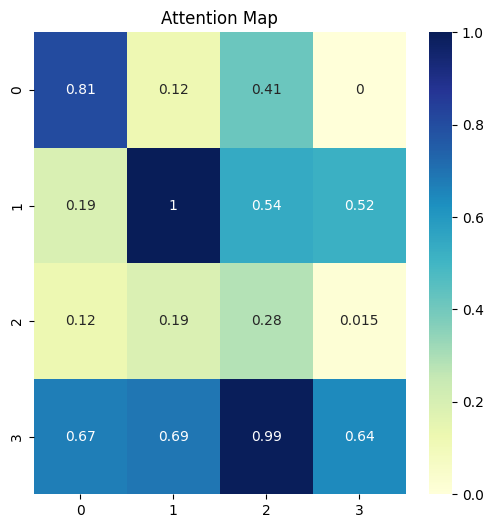

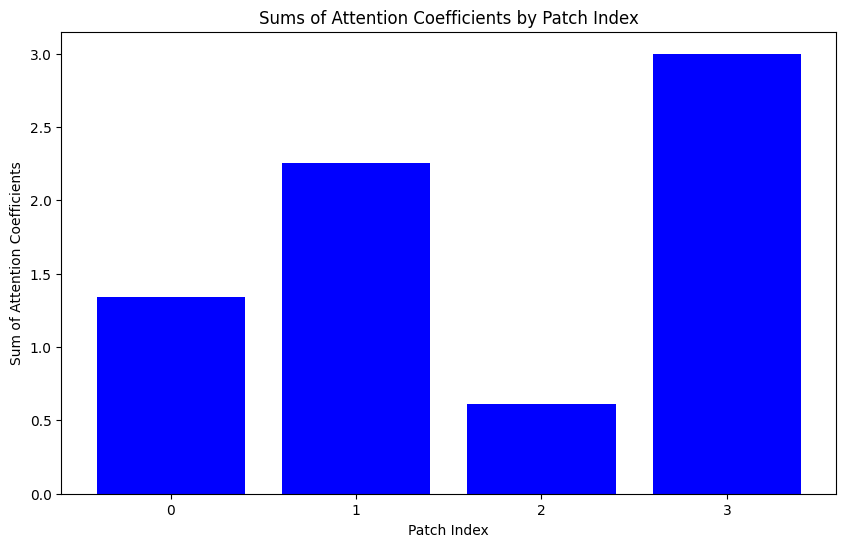

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.4098939895629883
Loss: 788.7590942382812


  5%|▌         | 1/20 [01:33<29:38, 93.59s/it]

Complete 0 th
torch.Size([283, 4, 16])
Row sums: [1.2609103 2.2917166 0.6722324 2.9764411]


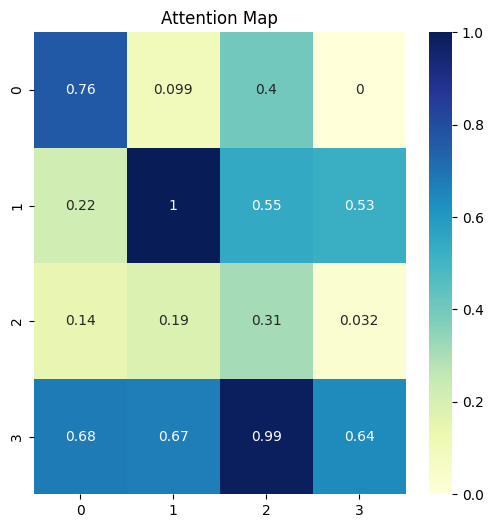

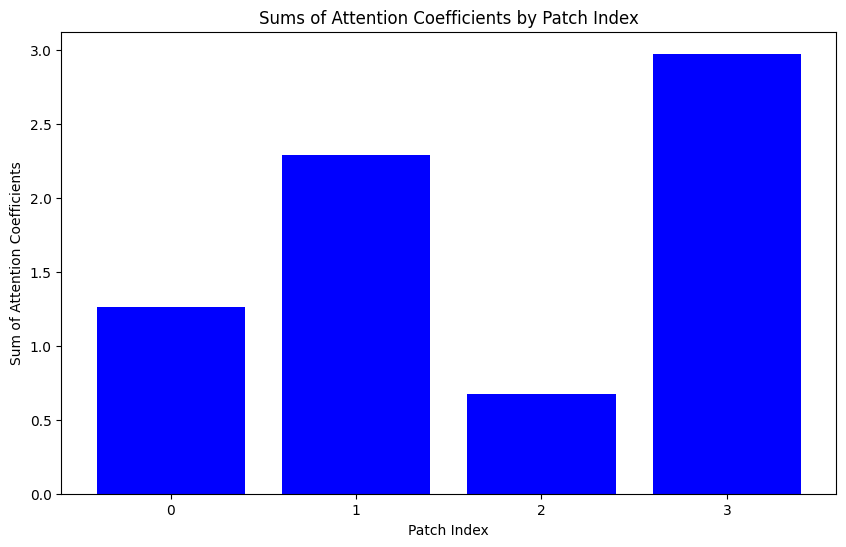

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.44876325130462646
Loss: 781.0469970703125


 10%|█         | 2/20 [03:06<27:59, 93.30s/it]

Complete 1 th
torch.Size([283, 4, 16])
Row sums: [1.207412   2.3307858  0.72770286 2.9867406 ]


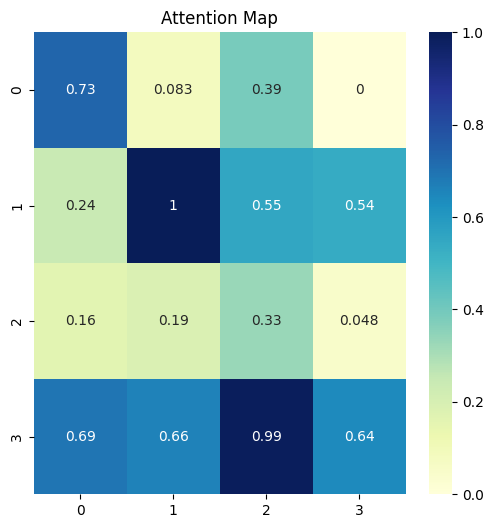

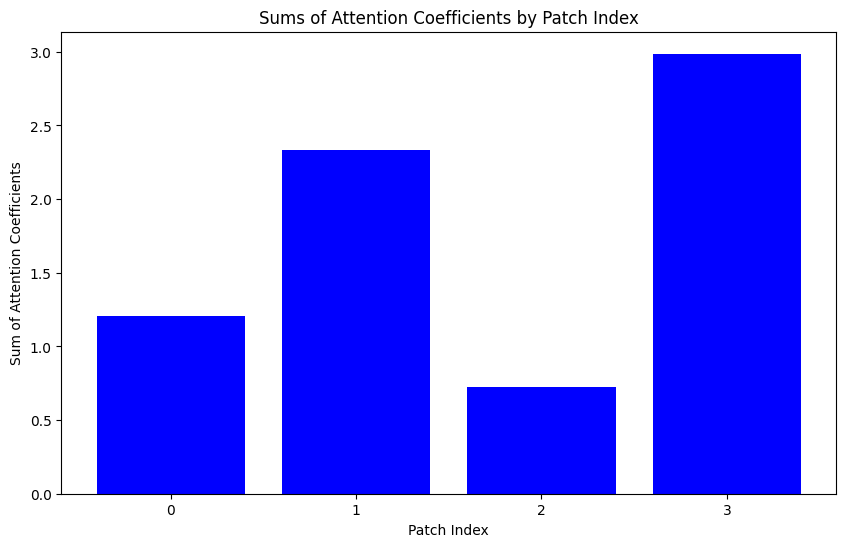

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.5159010887145996
Loss: 773.9493408203125


 15%|█▌        | 3/20 [04:40<26:26, 93.33s/it]

Complete 2 th
torch.Size([283, 4, 16])
Row sums: [1.1563429 2.364506  0.7844759 2.995679 ]


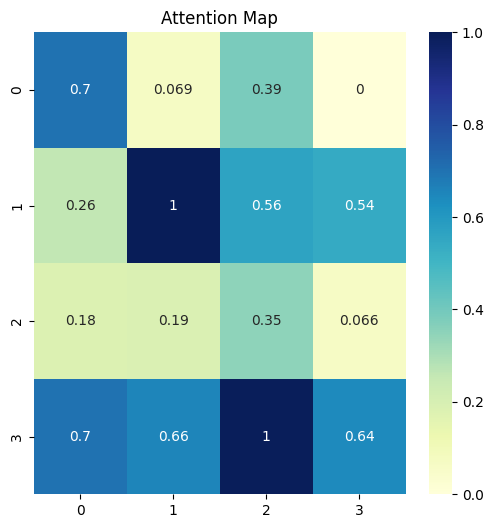

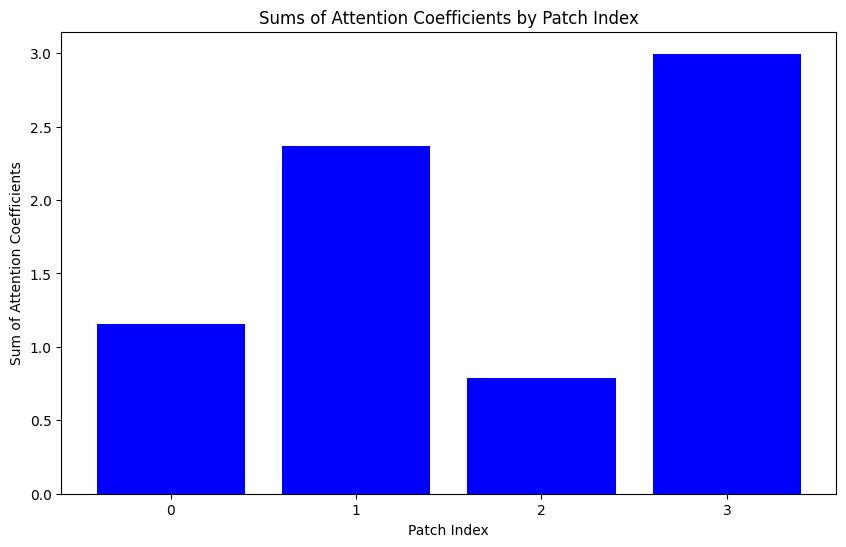

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.6501767039299011
Loss: 765.0853271484375


 20%|██        | 4/20 [06:14<24:59, 93.74s/it]

Complete 3 th
torch.Size([283, 4, 16])
Row sums: [1.1078231 2.3955126 0.8621746 3.0071375]


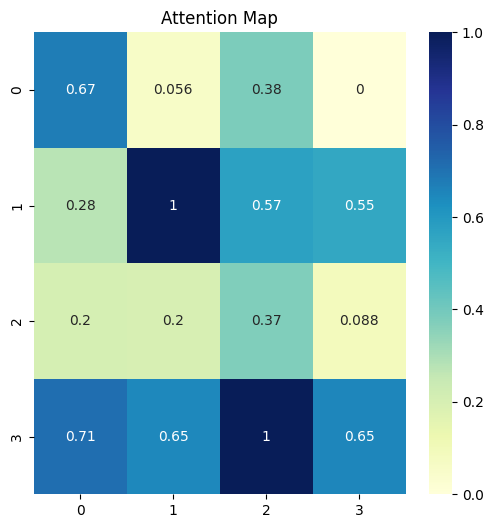

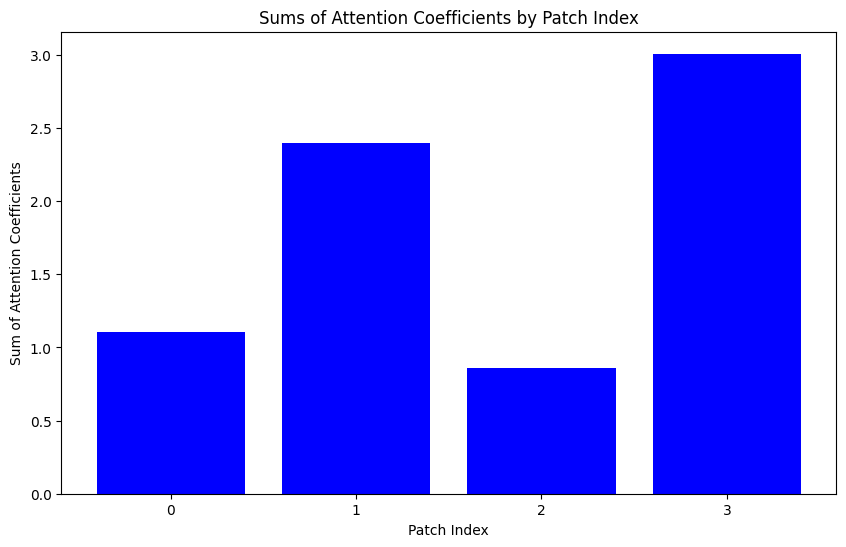

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.7279151678085327
Loss: 757.1539916992188


 25%|██▌       | 5/20 [07:48<23:28, 93.93s/it]

Complete 4 th
torch.Size([283, 4, 16])
Row sums: [1.060614  2.4161468 0.9386811 3.0141299]


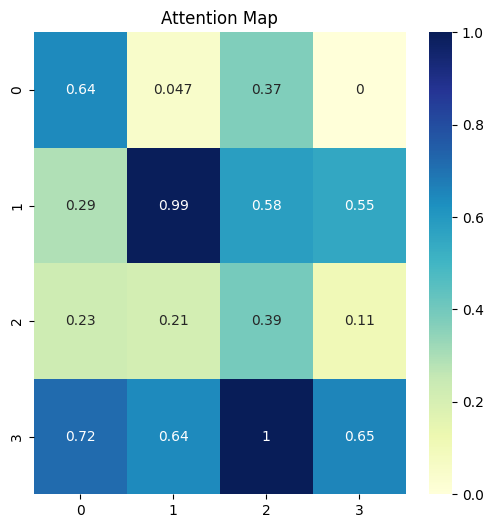

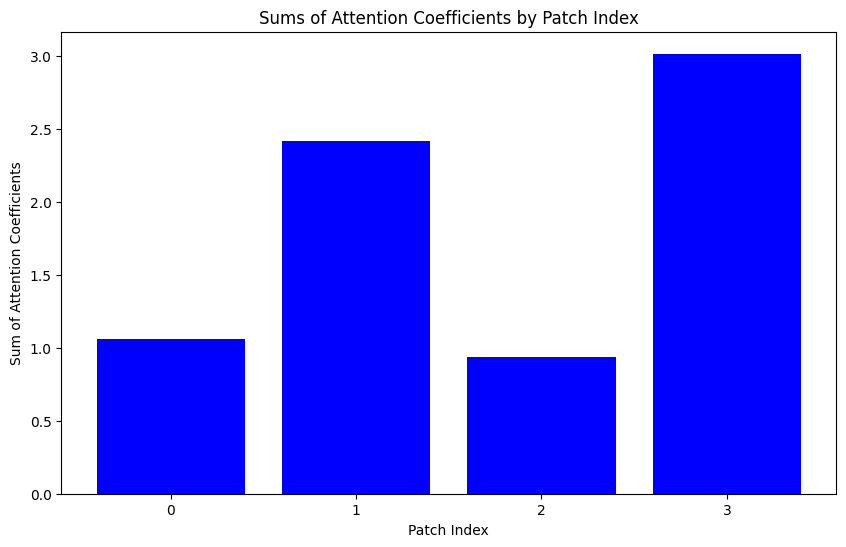

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.7773851752281189
Loss: 750.8681640625


 30%|███       | 6/20 [09:23<22:00, 94.31s/it]

Complete 5 th
torch.Size([283, 4, 16])
Row sums: [1.0217667 2.4344835 0.9964549 3.028023 ]


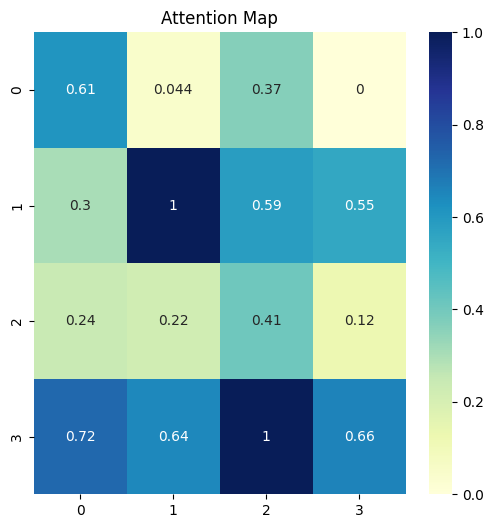

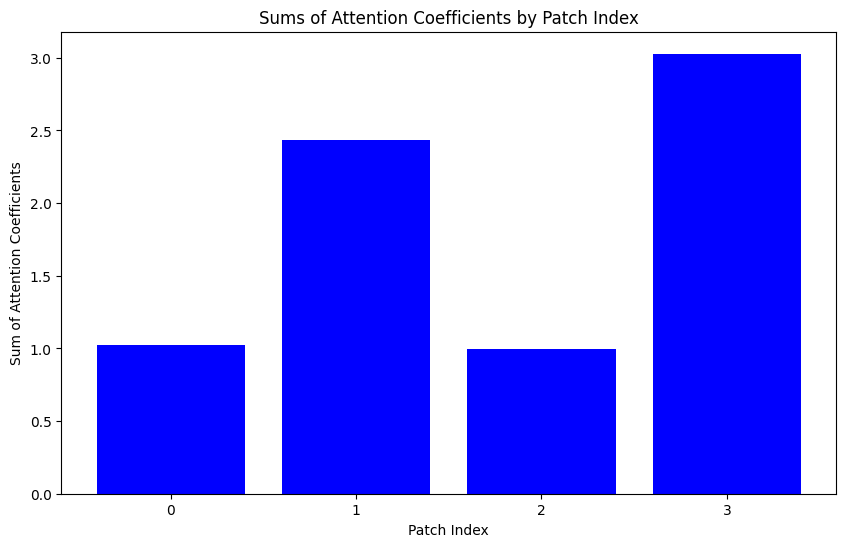

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8480565547943115
Loss: 746.4551391601562


 35%|███▌      | 7/20 [10:58<20:30, 94.62s/it]

Complete 6 th
torch.Size([283, 4, 16])
Row sums: [0.9898068 2.4419317 1.0372179 3.0351899]


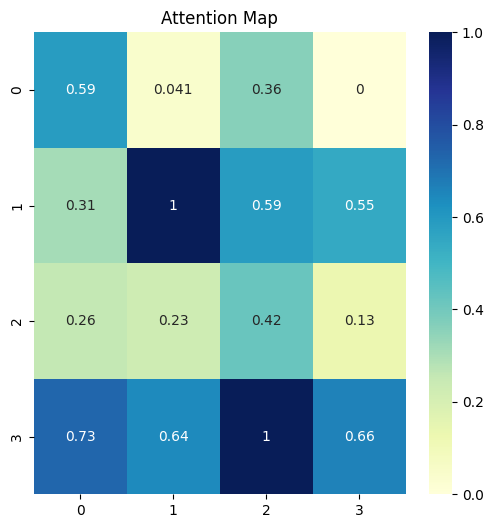

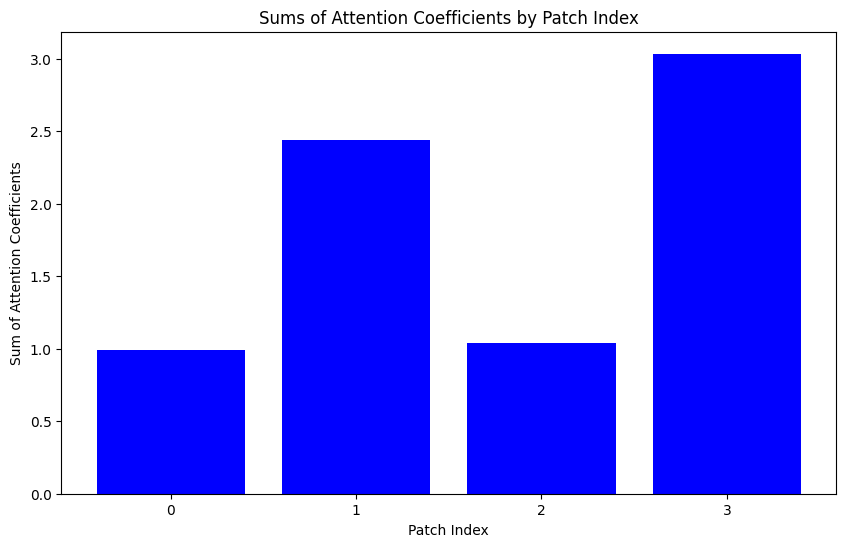

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8621907830238342
Loss: 743.2911376953125


 40%|████      | 8/20 [12:34<18:59, 94.99s/it]

Complete 7 th
torch.Size([283, 4, 16])
Row sums: [0.9633093 2.4458258 1.0824817 3.0366805]


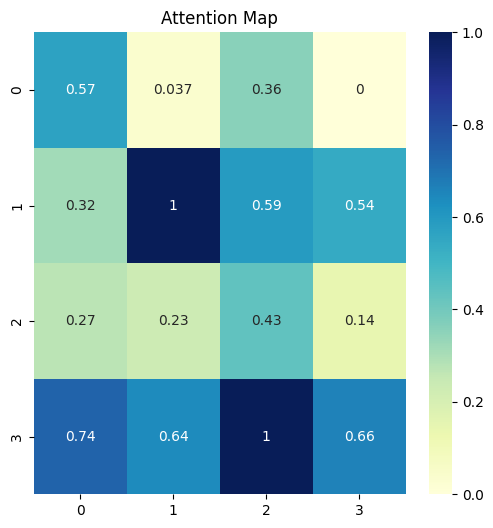

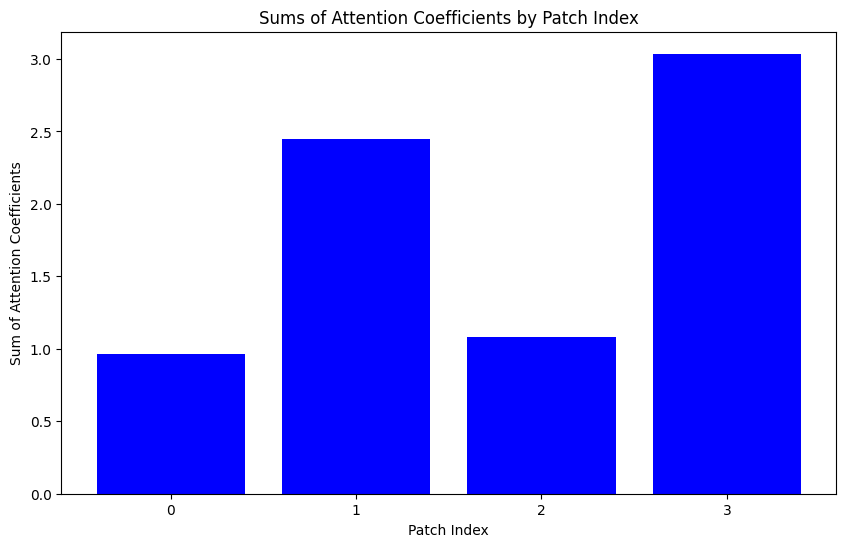

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.8939929604530334
Loss: 739.4259033203125


 45%|████▌     | 9/20 [14:10<17:28, 95.27s/it]

Complete 8 th
torch.Size([283, 4, 16])
Row sums: [0.9411825 2.4507697 1.1395798 3.0365326]


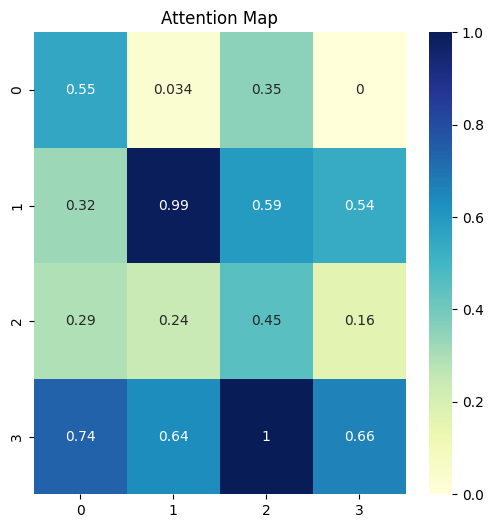

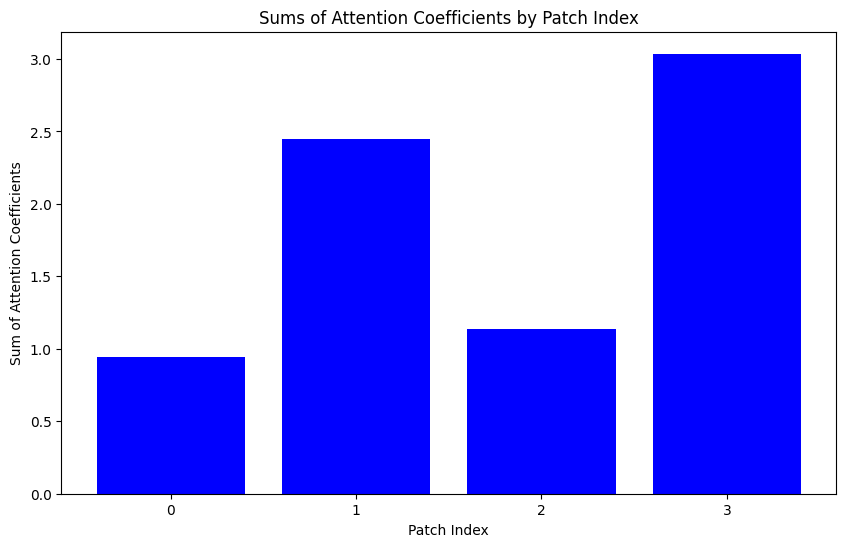

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9399293065071106
Loss: 735.4629516601562


 50%|█████     | 10/20 [15:46<15:53, 95.33s/it]

Complete 9 th
torch.Size([283, 4, 16])
Row sums: [0.92246544 2.4597301  1.2082758  3.0391223 ]


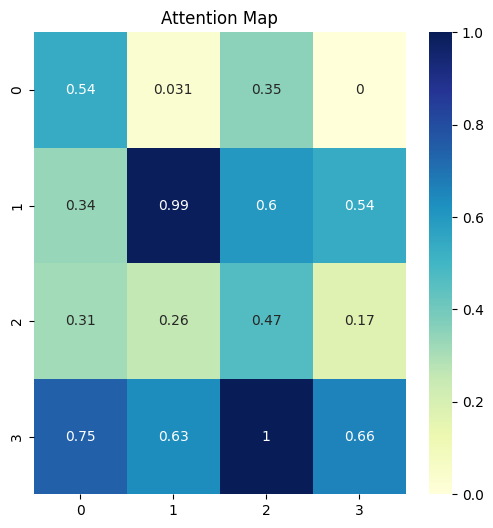

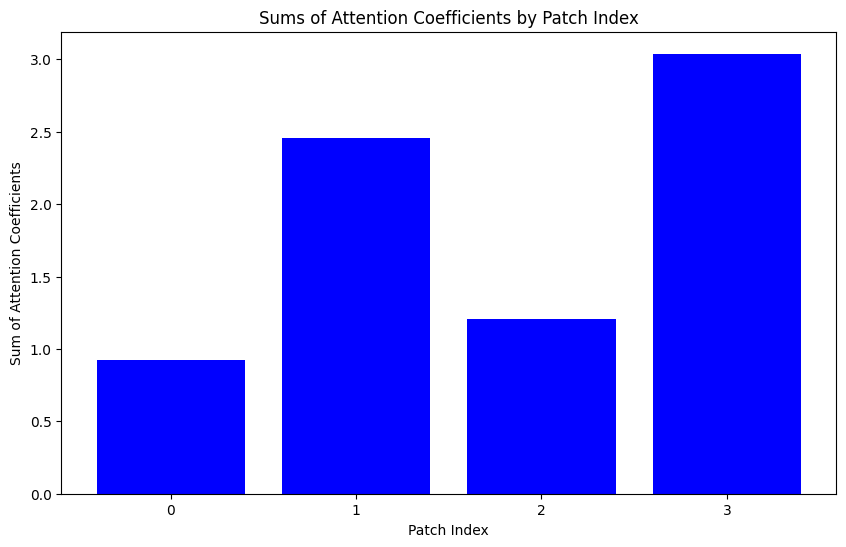

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9540635943412781
Loss: 732.2008056640625


 55%|█████▌    | 11/20 [17:21<14:19, 95.47s/it]

Complete 10 th
torch.Size([283, 4, 16])
Row sums: [0.90724236 2.473917   1.2845294  3.0491517 ]


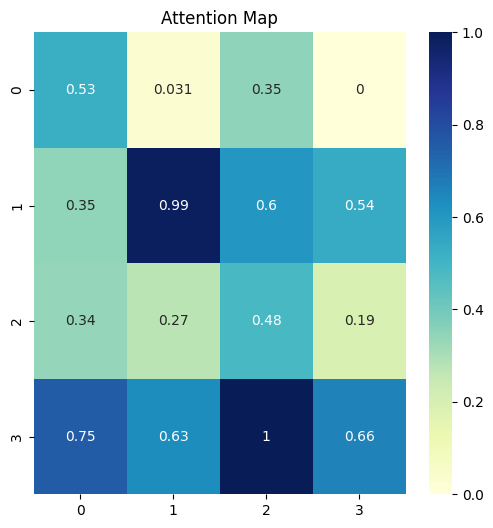

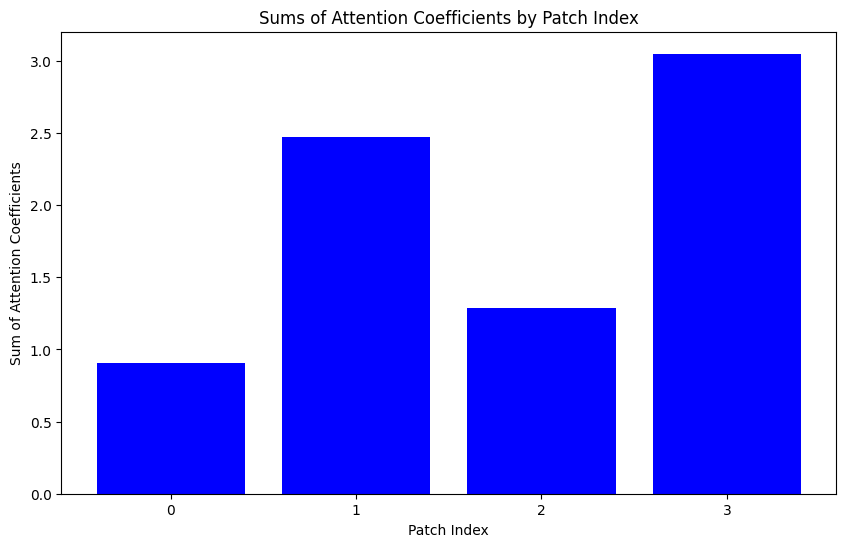

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9752650260925293
Loss: 729.9691162109375


 60%|██████    | 12/20 [18:56<12:42, 95.32s/it]

Complete 11 th
torch.Size([283, 4, 16])
Row sums: [0.8949188 2.4902196 1.3636751 3.0656655]


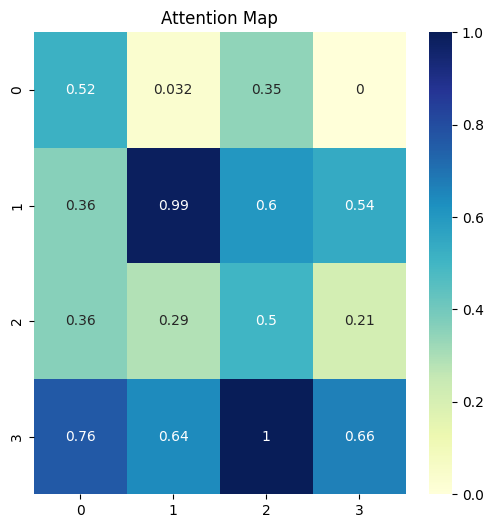

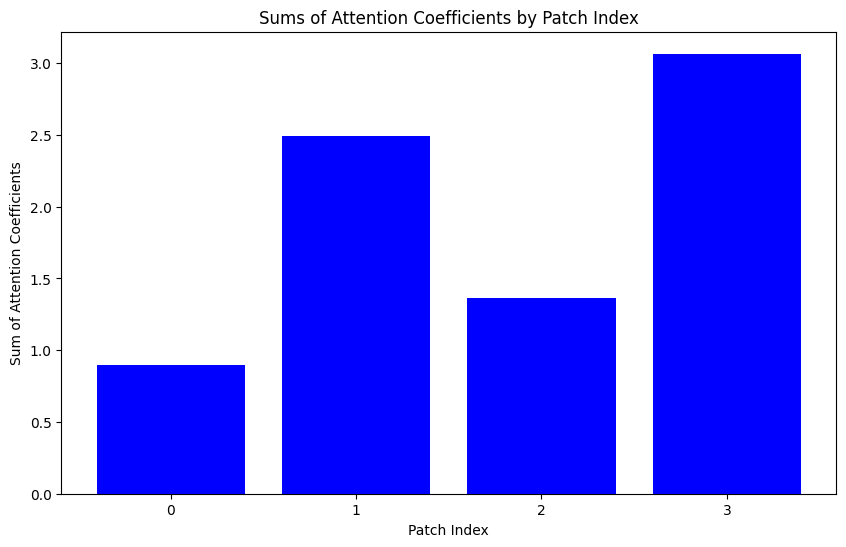

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9787985682487488
Loss: 728.6513061523438


 65%|██████▌   | 13/20 [20:32<11:07, 95.33s/it]

Complete 12 th
torch.Size([283, 4, 16])
Row sums: [0.88407147 2.5052056  1.4414082  3.0857198 ]


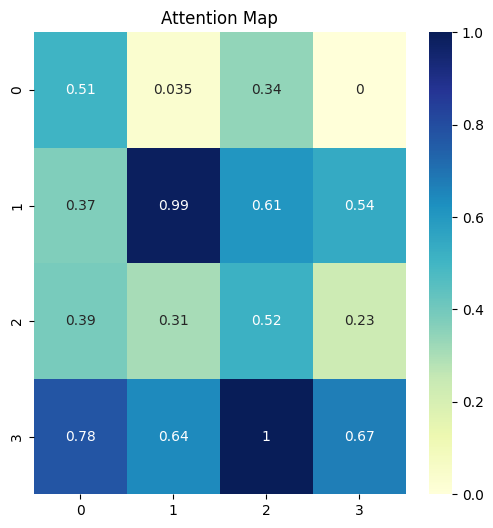

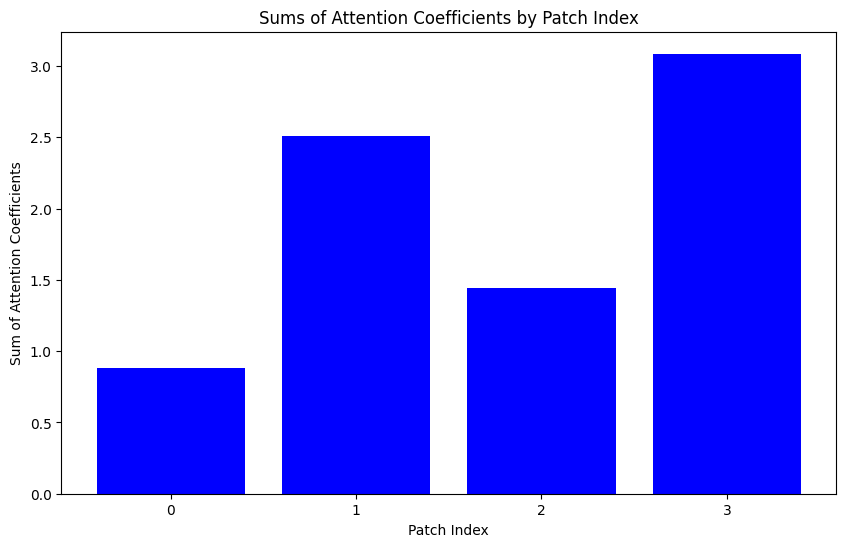

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.982332170009613
Loss: 727.8971557617188


 70%|███████   | 14/20 [22:07<09:31, 95.29s/it]

Complete 13 th
torch.Size([283, 4, 16])
Row sums: [0.87335145 2.5180135  1.5141406  3.1075509 ]


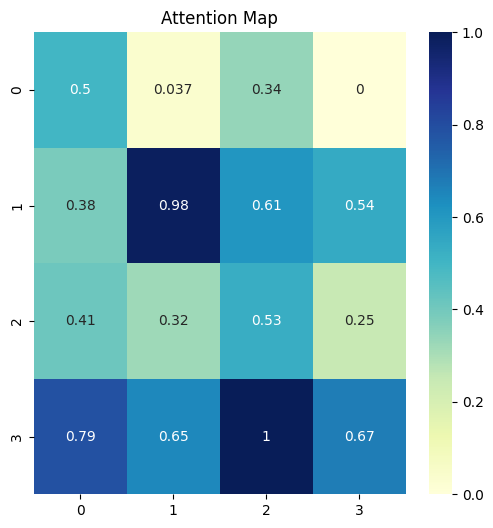

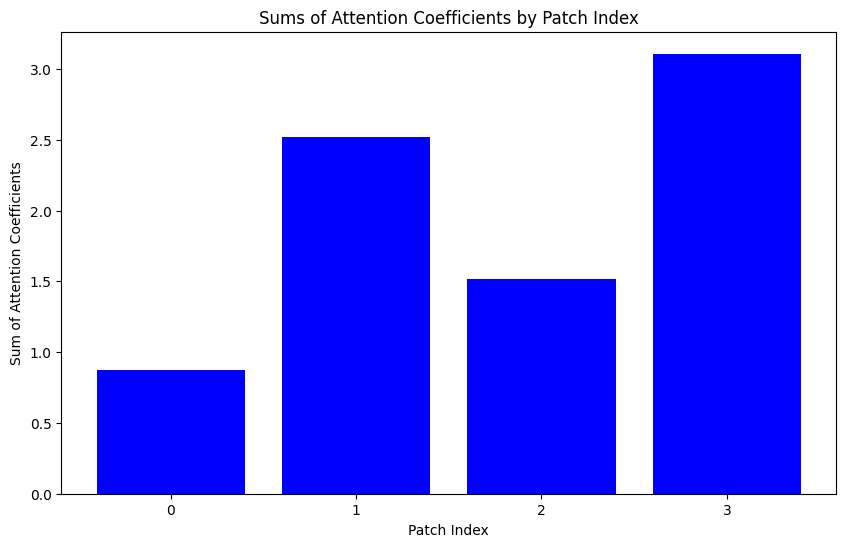

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9893993139266968
Loss: 727.4067993164062


 75%|███████▌  | 15/20 [23:42<07:56, 95.29s/it]

Complete 14 th
torch.Size([283, 4, 16])
Row sums: [0.8620074 2.5287724 1.5804342 3.1299791]


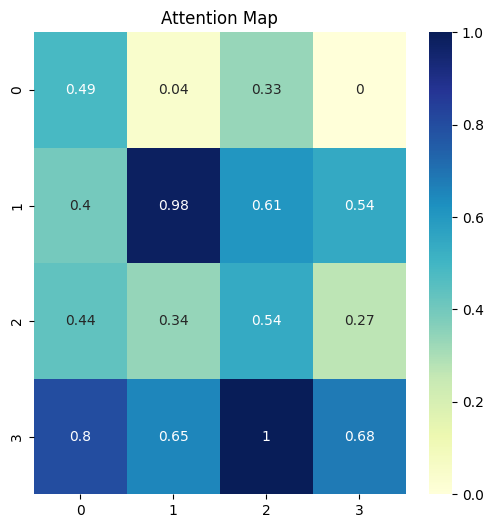

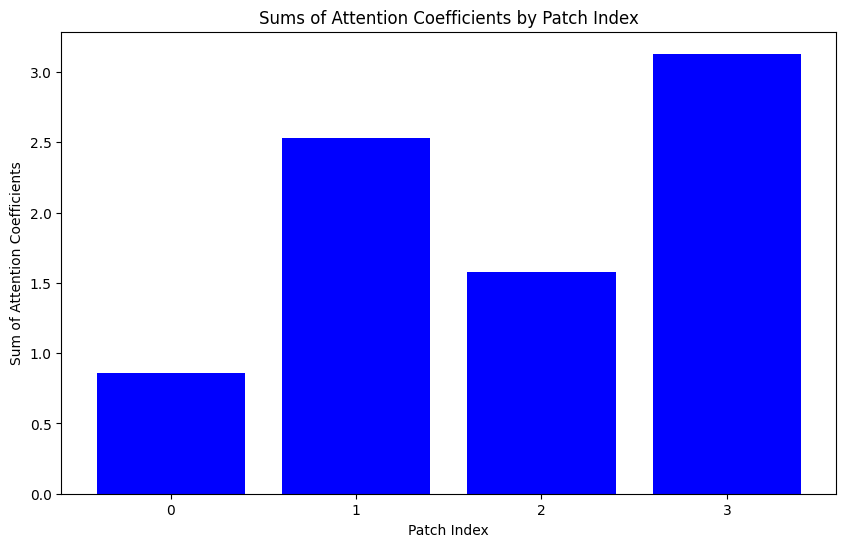

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9893993139266968
Loss: 727.04931640625


 80%|████████  | 16/20 [25:18<06:21, 95.30s/it]

Complete 15 th
torch.Size([283, 4, 16])
Row sums: [0.8498709 2.5379088 1.64081   3.1522884]


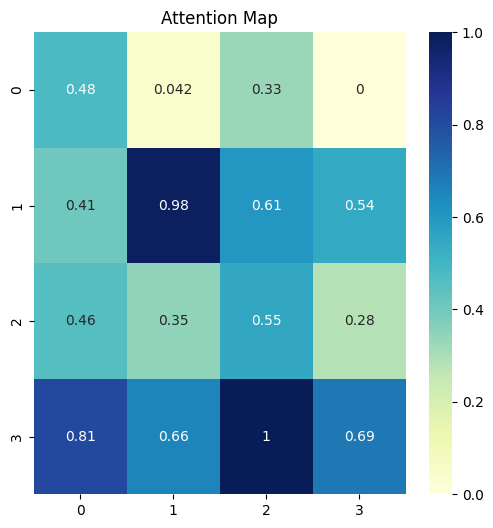

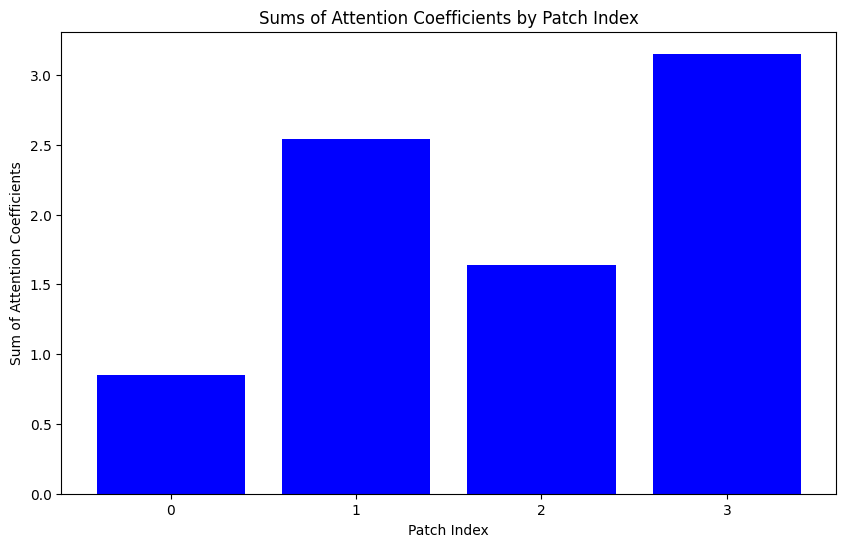

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9929328560829163
Loss: 726.7886962890625


 85%|████████▌ | 17/20 [26:53<04:45, 95.29s/it]

Complete 16 th
torch.Size([283, 4, 16])
Row sums: [0.83719486 2.5461233  1.6965746  3.1742435 ]


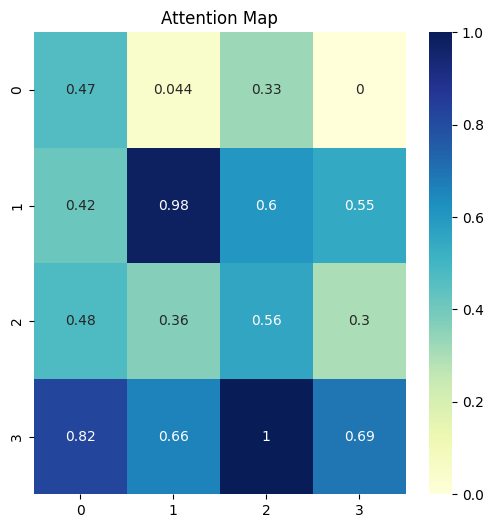

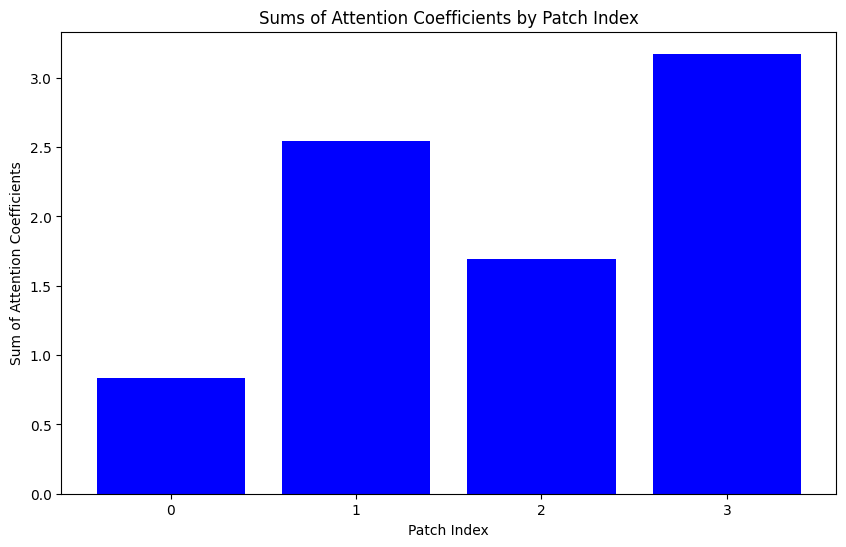

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9929328560829163
Loss: 726.6129150390625


 90%|█████████ | 18/20 [28:28<03:10, 95.21s/it]

Complete 17 th
torch.Size([283, 4, 16])
Row sums: [0.82436824 2.5540118  1.7488782  3.1958687 ]


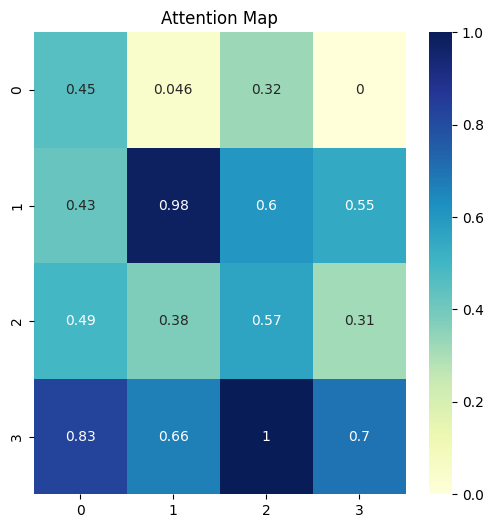

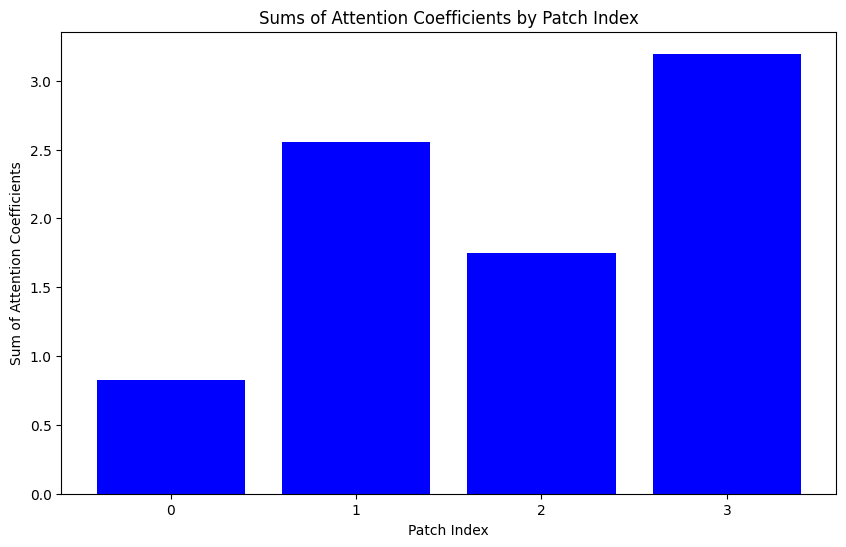

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9929328560829163
Loss: 726.5090942382812


 95%|█████████▌| 19/20 [30:03<01:35, 95.16s/it]

Complete 18 th
torch.Size([283, 4, 16])
Row sums: [0.81172645 2.5620692  1.7986506  3.2173119 ]


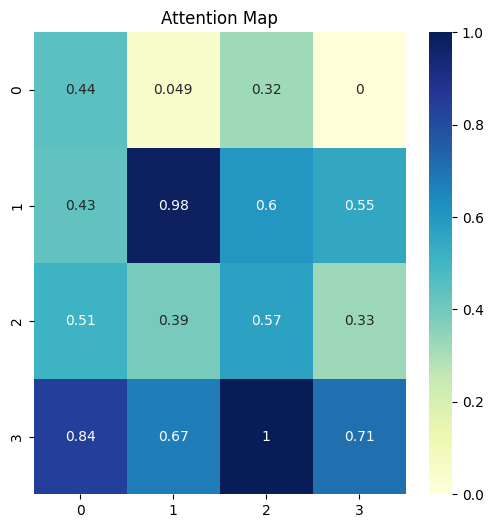

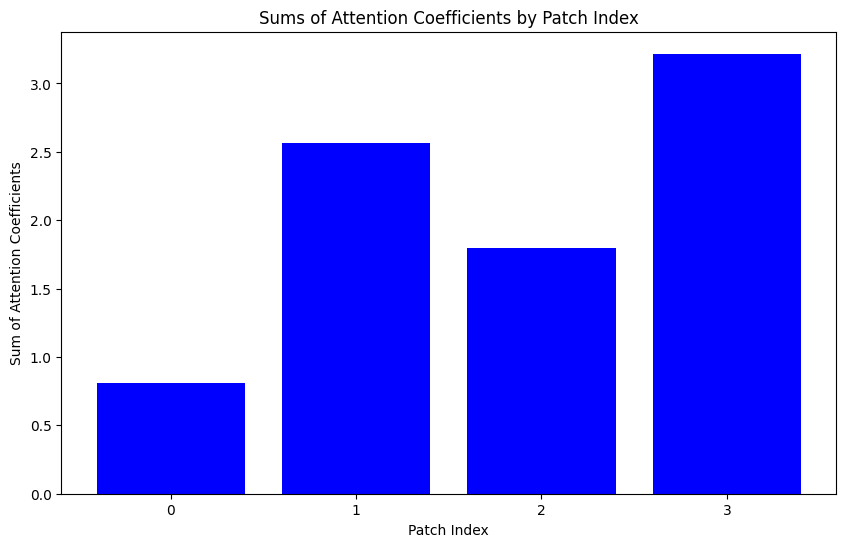

/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


Accuracy: 0.9929328560829163
Loss: 726.4552001953125


100%|██████████| 20/20 [31:38<00:00, 94.91s/it]

Complete 19 th
Model parameters saved.


In [19]:
# Training the model
for iepoch in tqdm(range(20)):
    optimizer.zero_grad()
    X_tensor = torch.tensor(X_train)
    predictions = model(X_tensor.float()).squeeze(1)
    
    label = torch.tensor(y_train)
    for i in range(len(label)):
        label[i] = 0 if label[i] == 1 else 1
    
    loss = criterion(predictions, label.float())
    acc = binary_accuracy(predictions, label)
    print(f'Accuracy: {acc}')
    print(f'Loss: {loss}')
    
    loss.backward()
    optimizer.step()
    print(f"Complete {iepoch} th")

# Save the model parameters
torch.save(model.state_dict(), model_save_path)
print("Model parameters saved.")

torch.Size([78, 4, 16])
Row sums: [1.0047963 3.183377  1.4706175 3.6448889]


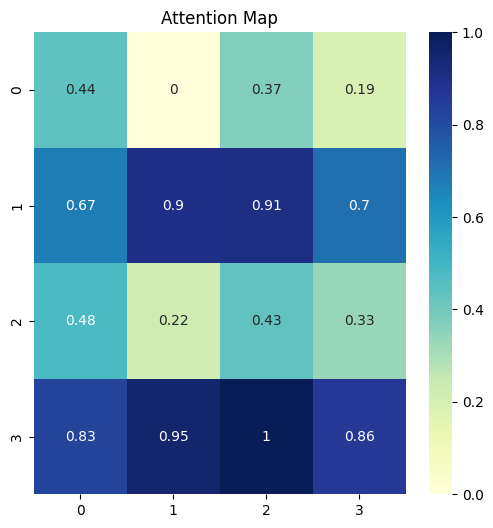

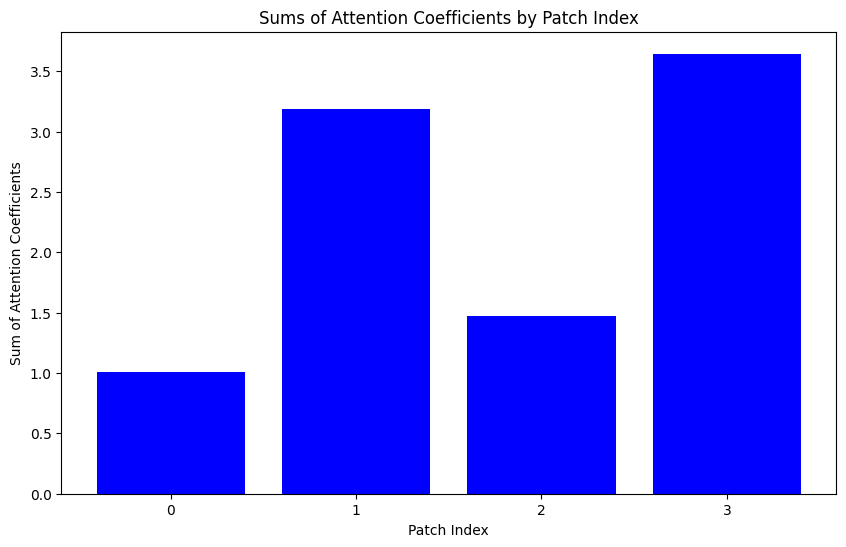


Accuracy: 0.9871794581413269

Loss: 164.62571716308594

AUROC: 0.9993408042188531



/tmp/ipykernel_193796/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [21]:
from sklearn.metrics import roc_auc_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)
for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Calculate AUROC
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy
auroc = roc_auc_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

In [47]:
# # Now load the model and make predictions on a single data sample
# # Create a new instance of the model and load the saved parameters
# loaded_model = QSANN_text_classifier(4, 4, 2, 1, 1)
# loaded_model.load_state_dict(torch.load(model_save_path))
# loaded_model.eval()
# print("Model loaded and ready for inference.")


In [22]:
# Select a single sample from the test set
single_sample = torch.tensor(X_test[0:1].astype(np.float32))  # Select one sample


In [23]:
# # Make a prediction for the single sample
# with torch.no_grad():
#     prediction = loaded_model(single_sample).squeeze()
#     predicted_class = (torch.round(torch.sigmoid(prediction))).item()
#     print(f"Predicted class for the sample: {predicted_class}")


In [24]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [25]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(4, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
)

Row sums: [2.8529425 2.5555809 3.1938367 3.2585492]


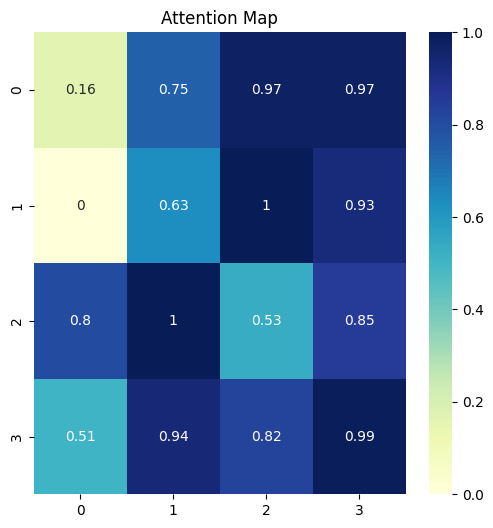

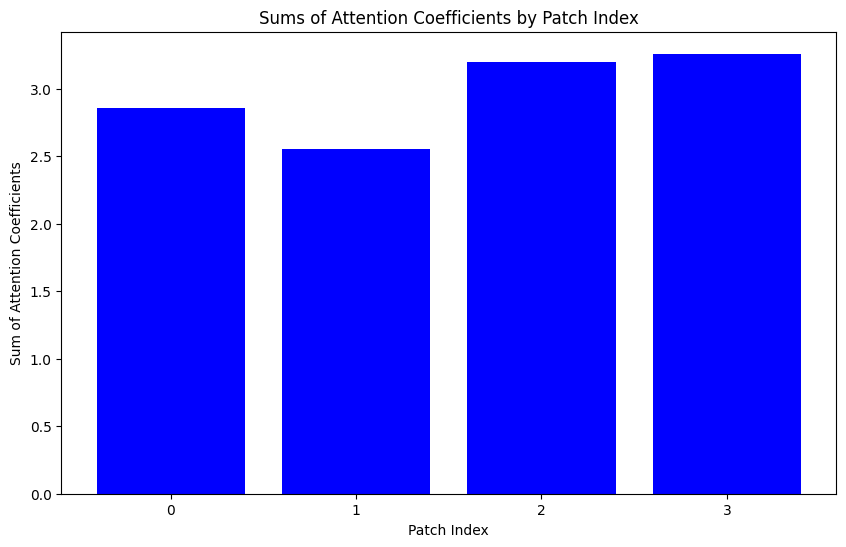

Predicted class for the sample: 1.0
Row sums: [2.8529425 2.5555809 3.1938367 3.2585492]


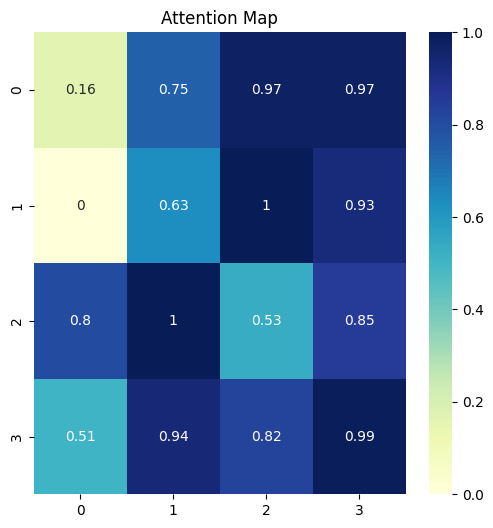

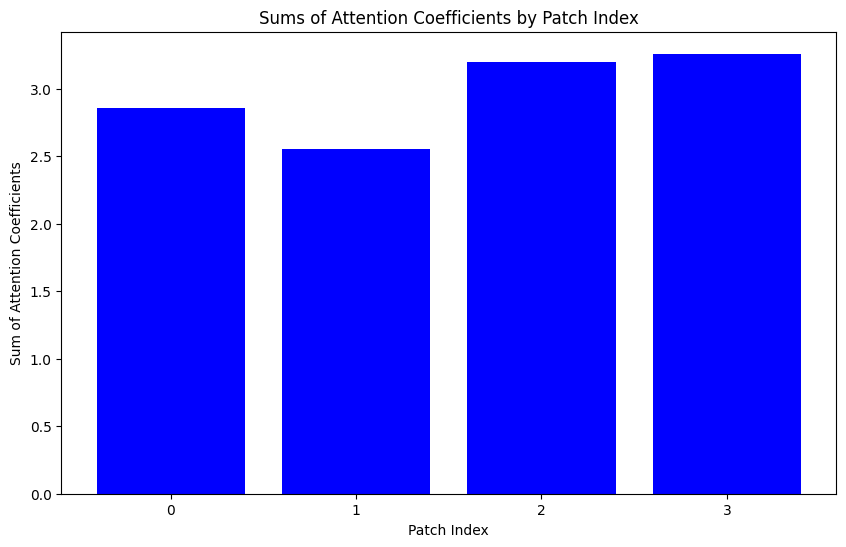

Extracted attention values: tensor([[[0.6942, 0.9071, 0.9904, 0.9904],
         [0.6368, 0.8656, 0.9991, 0.9729],
         [0.9288, 0.9996, 0.8309, 0.9466],
         [0.8202, 0.9768, 0.9361, 0.9963]]])


In [26]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    # predicted_class = (torch.round(torch.sigmoid(prediction))).item()
    print(f"Predicted class for the sample: {prediction}")
    # print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

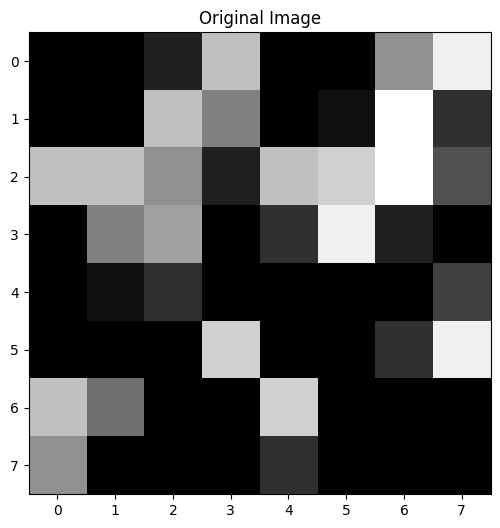

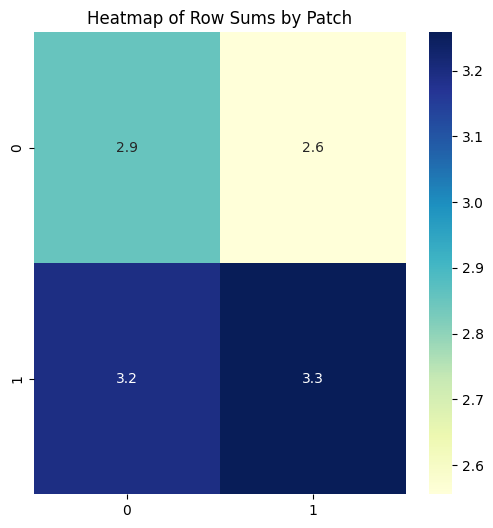

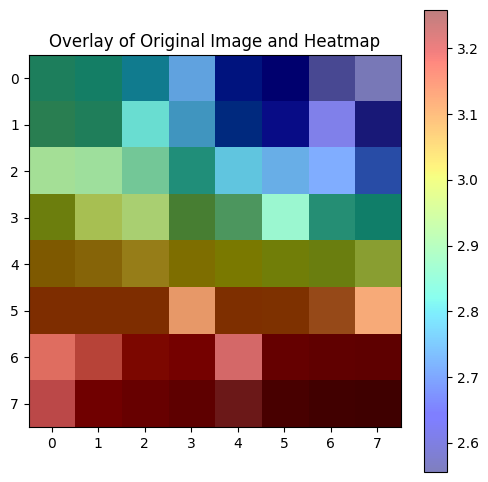

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(2, 2)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.5, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(X_test[0:1].astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = single_sample.squeeze().reshape(8, 8).numpy()  # Reshape to 2D

# Example row sums based on output
row_sums =[2.8529425, 2.5555809, 3.1938367, 3.2585492]

# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(2, 2))


-----------------------------------------